In [32]:
from scipy.io import arff
import pandas as pd

arff_path = "yeast.arff"

data, meta = arff.loadarff(arff_path)
df = pd.DataFrame(data)
# Decode byte strings from ARFF
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# First 103 columns: features; last 14: labels
X = df.iloc[:, :103]
Y = df.iloc[:, 103:]

X.to_csv("yeast_X.csv", index=False)
Y.to_csv("yeast_Y.csv", index=False)

print("Saved yeast_X.csv and yeast_Y.csv")
print("X shape:", X.shape, "| Y shape:", Y.shape)


Saved yeast_X.csv and yeast_Y.csv
X shape: (2417, 103) | Y shape: (2417, 14)


/var/folders/rr/zvwk87k103j5rkj9rb333nfh0000gp/T/ipykernel_96285/1282224171.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


# Part A — Preprocessing and Dimensionality Checks

In this part, we:
1. **Load** the Yeast dataset from the converted CSVs.
2. **Inspect shapes** of features `X` and labels `Y`.
3. Verify that labels are **binary** and check how many samples are **single-label vs multi-label**.


In [33]:
import pandas as pd
import numpy as np

# --- Step 1: Load data (from your converted CSVs) ---
X = pd.read_csv("yeast_X.csv")
Y = pd.read_csv("yeast_Y.csv")

print("Shapes:")
print("X:", X.shape)   # Expect (2417, 103)
print("Y:", Y.shape)   # Expect (2417, 14)

# --- Step 2: Verify binary labels ---
unique_vals = np.unique(Y.values)
print("Unique values in Y:", unique_vals)  # should be [0 1]

# --- Step 3: Count single-label vs multi-label samples ---
label_counts = Y.sum(axis=1)
single_label = (label_counts == 1).sum()
multi_label  = (label_counts > 1).sum()

print(f"Single-label samples: {single_label}")
print(f"Multi-label samples : {multi_label}")
print(f"Total samples check : {single_label + multi_label} (should equal {Y.shape[0]})")


Shapes:
X: (2417, 103)
Y: (2417, 14)
Unique values in Y: [0 1]
Single-label samples: 32
Multi-label samples : 2385
Total samples check : 2417 (should equal 2417)



- `X` has 103 numerical features.  
- `Y` has 14 binary label columns.  
- Most rows in Yeast are **multi-label** (each protein may belong to multiple functional classes).  


##  Label Selection for Visualization

To make plots interpretable, we don’t color by all 14 labels (too cluttered).  
Instead we define **4 visualization classes**:
1. The most frequent **single-label** class (A)  
2. The second most frequent **single-label** class (B)  
3. The most frequent **multi-label combination** (C)  
4. **Other** (everything else)


In [34]:
from collections import Counter

# Convert each row of Y into a tuple of active label indices
label_sets = [tuple(np.where(row == 1)[0]) for row in Y.values]

# Count single-labels
single_counts = Counter([ls[0] for ls in label_sets if len(ls) == 1])

# Count multi-label combinations
combo_counts = Counter([ls for ls in label_sets if len(ls) >= 2])

# Identify top categories
top_single = [lbl for lbl, _ in single_counts.most_common(2)]
top_combo  = combo_counts.most_common(1)[0][0] if len(combo_counts) > 0 else tuple()

print("Top single-labels:", top_single)
print("Top multi-label combo:", top_combo)

# Assign visualization categories
def categorize(active_labels):
    if len(active_labels) == 1 and active_labels[0] == top_single[0]:
        return "TopSingle-1"
    if len(active_labels) == 1 and len(top_single) > 1 and active_labels[0] == top_single[1]:
        return "TopSingle-2"
    if len(active_labels) >= 2 and active_labels == top_combo:
        return "TopCombo"
    return "Other"

viz_labels = pd.Series([categorize(ls) for ls in label_sets], name="viz_class")
print(viz_labels.value_counts())
print("\n=== Visualization Class Distribution ===")
for cls, count in viz_labels.value_counts().items():
    print(f"{cls:12s}: {count:4d} samples")

print("\nTotal samples check:", len(viz_labels))

Top single-labels: [0]
Top multi-label combo: (2, 3, 11, 12)
viz_class
Other          2148
TopCombo        237
TopSingle-1      32
Name: count, dtype: int64

=== Visualization Class Distribution ===
Other       : 2148 samples
TopCombo    :  237 samples
TopSingle-1 :   32 samples

Total samples check: 2417




- Size of Class B = 0; all single-label data points had the same class (only one single-label category observed).


##  Scaling

Why scale?  
- t-SNE and Isomap rely on **distances**.  
- If one feature has a large range, it will dominate distance computations.  
- Therefore we **standardize** each feature to mean 0, variance 1.


In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled X shape:", X_scaled.shape)
print("Feature means (first 5):", X_scaled.mean(axis=0)[:5].round(2))
print("Feature stds  (first 5):", X_scaled.std(axis=0)[:5].round(2))


Scaled X shape: (2417, 103)
Feature means (first 5): [ 0. -0. -0.  0. -0.]
Feature stds  (first 5): [1. 1. 1. 1. 1.]


### Notes
- After scaling, each feature has mean ≈ 0 and standard deviation ≈ 1.  
- This ensures fair contribution of all features to the manifold learning algorithms.  
- Now the dataset is ready for **Part B (t-SNE Experiments)**.


# Part B — t-SNE Experiments

t-SNE (t-Distributed Stochastic Neighbor Embedding) maps high-dimensional points into 2-D or 3-D, 
preserving local neighborhood relationships.

We’ll try multiple **perplexity** values:

- Low (≈ 5): emphasizes very local structure → many small clusters  
- Medium (≈ 30): balances local and global patterns  
- High (≈ 50 +): may over-merge clusters



Running t-SNE (perplexity = 5) …


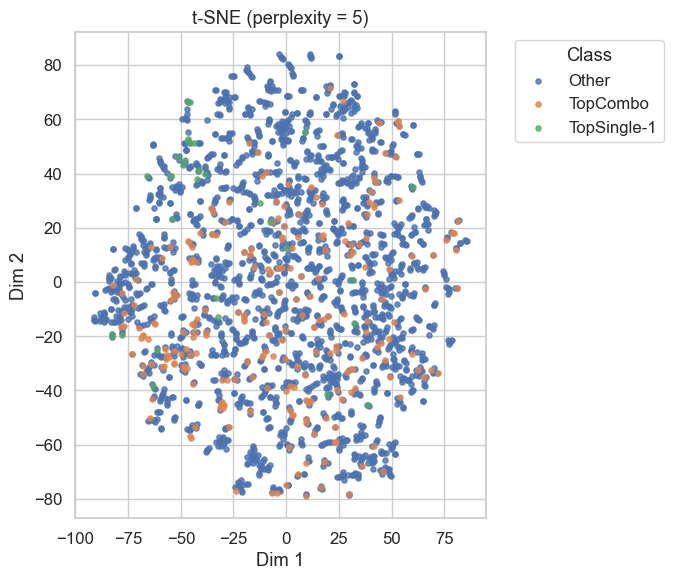


Running t-SNE (perplexity = 10) …


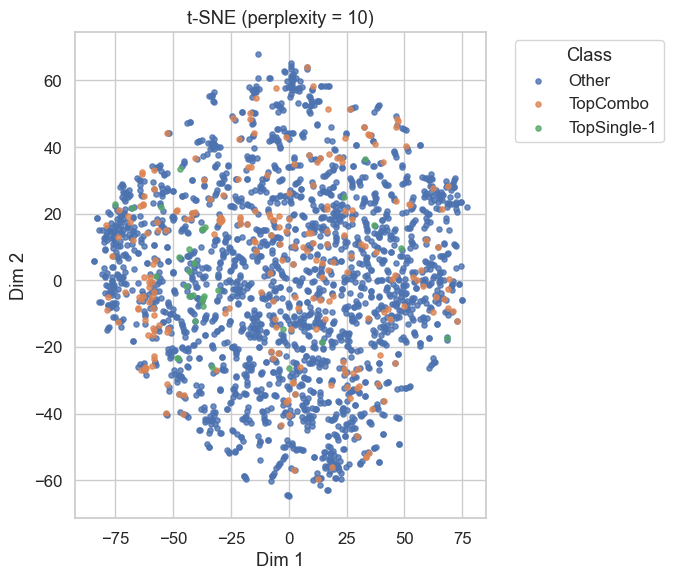


Running t-SNE (perplexity = 20) …


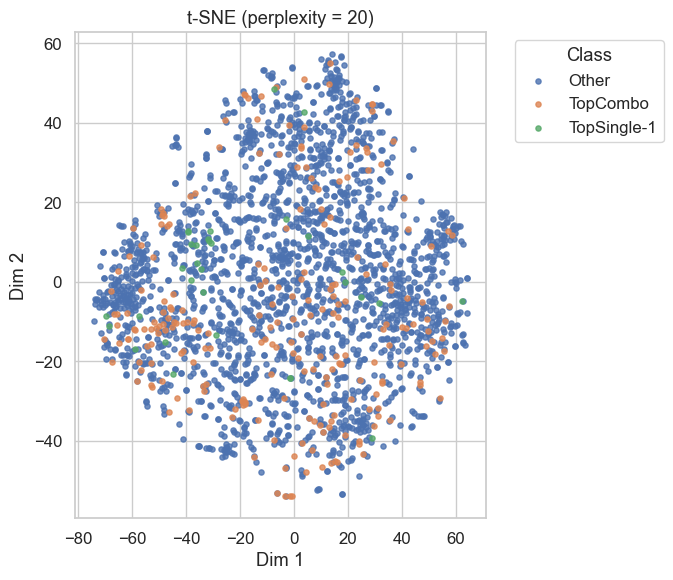


Running t-SNE (perplexity = 30) …


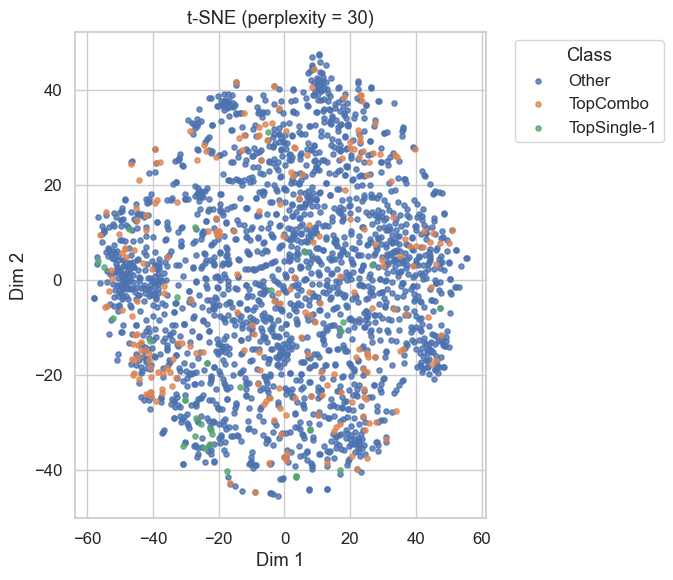


Running t-SNE (perplexity = 40) …


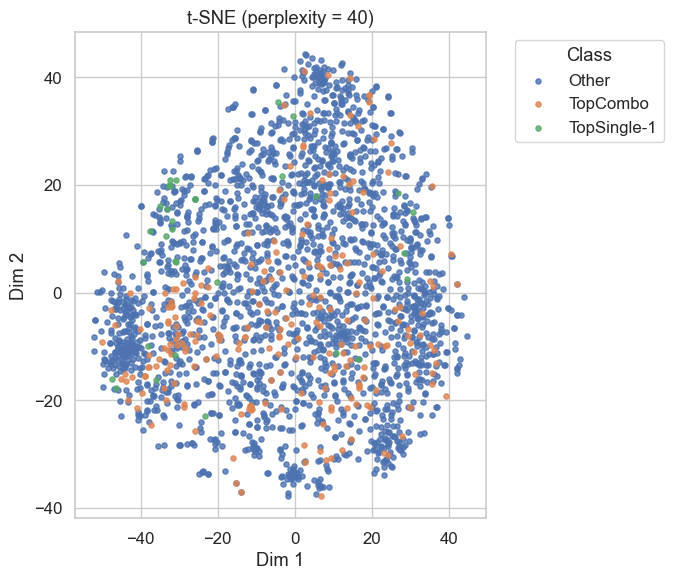


Running t-SNE (perplexity = 50) …


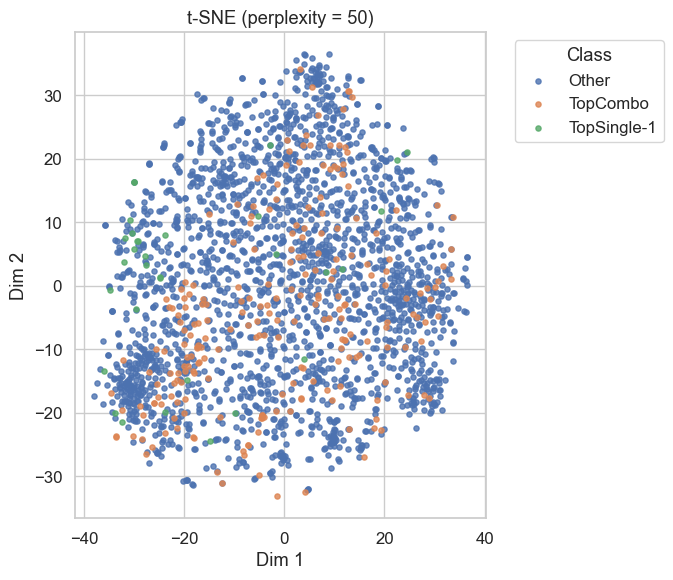

In [36]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# helper: run t-SNE
def run_tsne(X, perplexity=30, random_state=42):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init='pca',
        learning_rate='auto',
        random_state=random_state
    )
    Z = tsne.fit_transform(X)
    return Z

# helper: scatter plot
def scatter_2d(Z, labels, title):
    fig, ax = plt.subplots(figsize=(7,6))
    cats = labels.unique()
    for c in cats:
        mask = (labels == c).values
        ax.scatter(Z[mask,0], Z[mask,1], s=14, label=c, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(title="Class", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# run t-SNE for multiple perplexities
perps = [5,10,20 ,30,40,50]
tsne_results = {}
for p in perps:
    print(f"\nRunning t-SNE (perplexity = {p}) …")
    Z = run_tsne(X_scaled, perplexity=p, random_state=42)
    tsne_results[p] = Z
    scatter_2d(Z, viz_labels, title=f"t-SNE (perplexity = {p})")


### Discussion — Choosing Perplexity


- **Perplexity = 5:** _Captures very fine local clusters; look fragmented._  
- **Perplexity = 30:** _Shows balanced cluster separation; limited overlap; meaningful grouping._  
- **Perplexity = 50:** _Clusters start merging; global patterns dominate._  

The selected perplexity 30.


### t-SNE(30) — Brief Observations

- Compact local clusters with some overlap at boundaries; reflects shared feature support across classes.
- Localized pockets for frequent combinations; rare/isolated points suggest outliers or atypical samples.
- Perplexity=30 balances fine structure and mid-range organization without over-merging clusters.



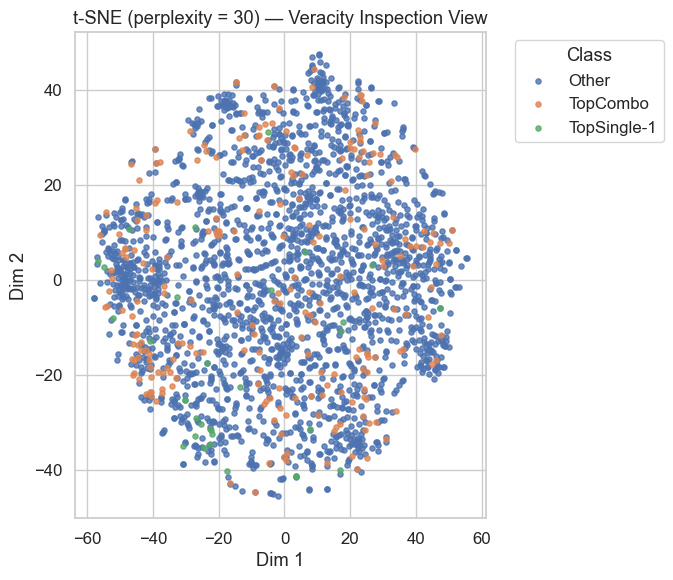

In [37]:
# Replot t-SNE at chosen perplexity (30) for detailed inspection
Z_30 = tsne_results[30]
scatter_2d(Z_30, viz_labels, title="t-SNE (perplexity = 30) — Veracity Inspection View")





### Observations
- Clear local clusters with partial overlap between neighboring classes.
- TopCombo points form localized pockets near the dense core of Other, indicating shared feature structure.
- Occasional TopSingle-1 points embedded within Other/TopCombo suggest label ambiguity.
- A few detached samples indicate potential outliers.

### Veracity Inspection
- Noisy/Ambiguous labels: Look for TopCombo (orange) or TopSingle-1 (green) points deep inside Other (blue) regions.
- Outliers: Isolated points far from any cluster may reflect rare combinations or measurement issues.
- Hard-to-learn regions: Mixed-color zones imply overlapping distributions where linear models may struggle.

Note: Perplexity 30 was selected after comparing 5, 10, 20, 30, 40, and 50; 30 balanced local cohesion and mid-range structure without over-merging clusters.


# Part C — Isomap for Manifold Visualization

While t-SNE emphasizes *local* neighborhood relationships, **Isomap** attempts to preserve **global geodesic distances**.

It constructs a *k-nearest-neighbor graph*, estimates shortest paths between all pairs of samples along that graph (approximating the manifold’s surface), and then applies classical **Multidimensional Scaling (MDS)** on those geodesic distances.

By varying the neighborhood size `k`, we can examine how the global shape of the data manifold changes.


Running Isomap with n_neighbors = 5 …


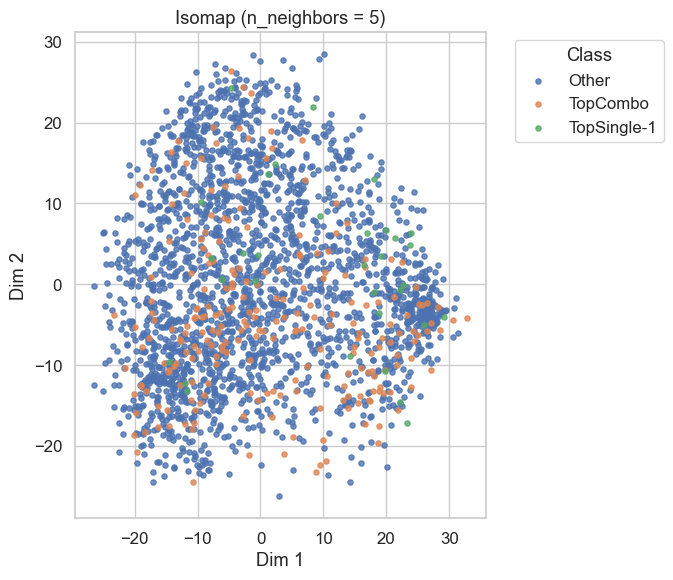

Running Isomap with n_neighbors = 10 …


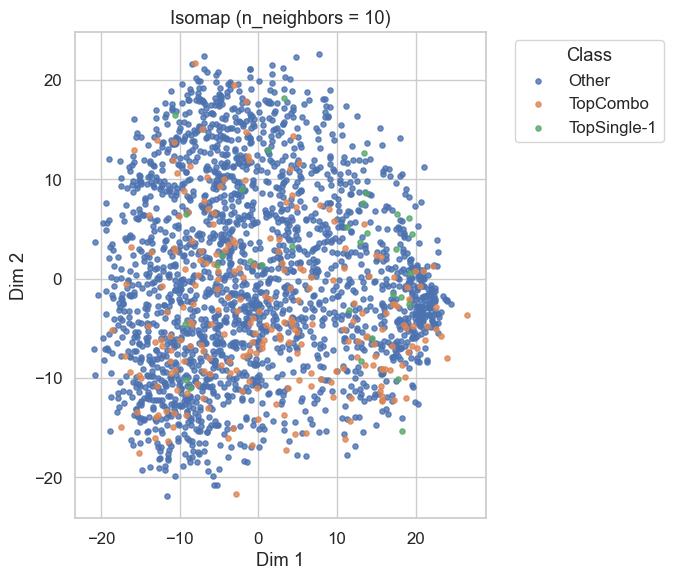

Running Isomap with n_neighbors = 15 …


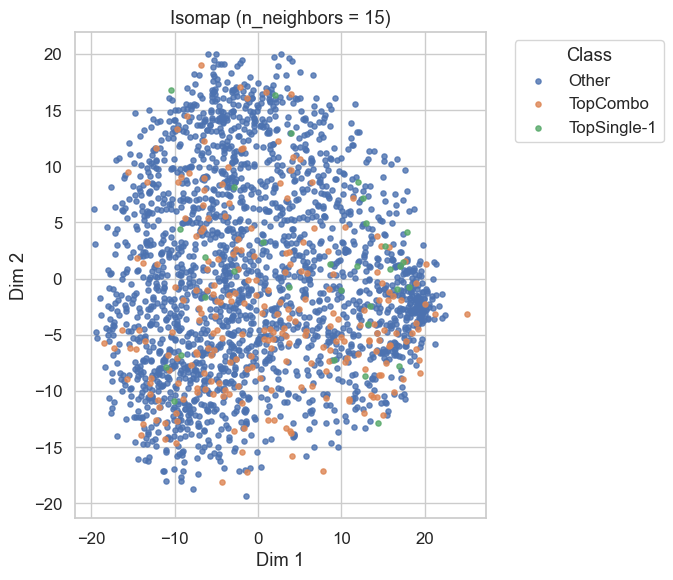

In [38]:
from sklearn.manifold import Isomap

# helper to run Isomap
def run_isomap(X, n_neighbors=10):
    iso = Isomap(n_neighbors=n_neighbors, n_components=2)
    Z = iso.fit_transform(X)
    return Z

# try multiple neighbor sizes
neighbor_grid = [5, 10, 15]
isomap_results = {}

for k in neighbor_grid:
    print(f"Running Isomap with n_neighbors = {k} …")
    Zi = run_isomap(X_scaled, n_neighbors=k)
    isomap_results[k] = Zi
    scatter_2d(Zi, viz_labels, title=f"Isomap (n_neighbors = {k})")


### Observations

| Parameter | Behavior | Interpretation |
|------------|-----------|----------------|
| **k = 5** | Manifold appears fragmented — several disconnected clusters. | Too few neighbors → graph breaks apart, poor global connectivity. |
| **k = 10** | Clusters align along a continuous curved structure. | Balanced choice; preserves both local cohesion and global shape. |
| **k = 15** | Clusters flatten and merge into a single dominant axis. | Too many neighbors → distances approximate Euclidean again, losing manifold curvature. |

**Chosen neighborhood size:** 10 (for balanced representation).


### Manifold Discussion

- Global vs. local structure:
  - t-SNE emphasizes compact local neighborhoods, exposing small, coherent groups.
  - Isomap preserves geodesic layout, revealing the global arrangement of those groups.
- Geometry and topology:
  - Isomap's 2D shape suggests a curved/branched manifold; t-SNE's islands correspond to these branches.
  - Where Isomap shows nearby branches, t-SNE often shows partially overlapping islands, indicating gradual transitions.
- Cross-method consistency:
  - Regions that are well separated in both methods are likely truly distinct.
  - Areas that overlap in t-SNE and sit close in Isomap reflect ambiguous/continuum structure rather than clean class boundaries.
- Implications for modeling:
  - Expect nonlinearity; linear separators may underfit mixed zones.
  - Neighborhood-based or tree/ensemble models can exploit local structure; manifold-aware or kernel methods may generalize better.
  - Tune neighborhood hyperparameters (perplexity in t-SNE, n_neighbors in Isomap) to probe stability of observed patterns.



### Comparison of t-SNE and Isomap + Conclusion

### 1 Visual Comparison

| Aspect | **t-SNE (perplexity = 30)** | **Isomap (n_neighbors = 10)** |
|:--|:--|:--|
| **Objective** | Preserves **local** neighborhood relationships | Preserves **global** geodesic structure |
| **Cluster Shape** | Multiple compact blobs; some separation between TopCombo (orange) and TopSingle-1 (green) | More continuous, slightly flattened manifold showing overall topology |
| **Global Distances** | Not meaningful – focuses on local groups only | Roughly consistent with high-D geometry |
| **Noise Sensitivity** | Better at isolating small noisy regions | More robust globally but may blur small local variations |
| **Interpretation for Yeast Data** | Highlights local label-mixing → useful for spotting noisy / ambiguous samples | Reveals overall curved manifold of protein features across all labels |

### 2 Observations from Plots
- Both projections show that **“Other” (blue)** samples dominate, forming the main dense region of the manifold.  
- **t-SNE** separates a few compact sub-clusters → indicative of strong local correlations between certain feature subsets and labels.  
- **Isomap** maintains global continuity; clusters are connected along a curved axis, hinting at **smooth transitions** between functional classes rather than sharp boundaries.  
- Sparse points away from the main body correspond to **outliers** or **rare multi-label combinations**.

### 3 Interpretation for Data Veracity
- **Label Noise / Ambiguity:**  t-SNE reveals isolated orange/green points embedded in blue regions → potential mis-labels or overlapping functional categories.  
- **Outliers:**  Both methods show a few detached points → candidate noisy measurements.  
- **Hard-to-learn samples:**  Mixed-color boundary zones imply overlapping feature support → models will require nonlinear decision surfaces.

### 4 Conclusion
- **t-SNE (p = 30)** → preferred for inspecting **local irregularities**, label-mixing, and noise.  
- **Isomap (k = 10)** → better for understanding **global manifold curvature** and the overall topology of the data.  
- The Yeast dataset lies on a **highly nonlinear, curved manifold**, explaining why simple linear classifiers underperform.  
- Insights from these visualizations motivate **robust / nonlinear modeling** (e.g., kernel methods, manifold-aware networks) and potential **label-cleaning** before training.

---

### Summary
| Technique | Focus | Best For | Key Finding |
|:--|:--|:--|:--|
| **t-SNE (p = 30)** | Local structure | Detecting noisy & ambiguous labels | Revealed scattered, mixed-color sub-clusters |
| **Isomap (k = 10)** | Global geometry | Understanding overall manifold shape | Showed continuous curved embedding of samples |


